# Natural Gas Prediction Model

## Purpose: 
To predict gas prices using both a Linear Regression Model and a Sinusoidal Regression.  Then compare which gives a more accurate analysis on Natural Gas Prices dataset from the JP Morgan job simulation on Forage. 


## Bottom-Line Up Front

The Linear Regression model had on average $0.167 error and the Sinusoidal model had on average $0.220

Linear Model performs better than Sinusoidal Model by $0.053.

Sinusoidal Model assumes smooth symmetric pattern, the plot does not follow a perfect wave, the one hot encoding allows each month to have its own coefficient. 


In [61]:
# Install libraries
!python -m pip install --upgrade pip -q
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl -q
!pip install notebook -q
!pip install nbconvert -q
!pip install tabulate -q

In [62]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [63]:
# Load the dataset
df = pd.read_csv('Nat_Gas.csv')
df_1 = pd.read_csv('Nat_Gas.csv')

## Methodology
### Linear Regression Model
- Load relevant libraries
- Import and format the data
- Create a time index by one hot encoding the month
- Split the model into test and training dataset chronologically by year, using the last year as the test year.
- After running the LinearRegression() function, get the model.coef[0] and the model.intercept and use it to calculate the price. 
- Create a function to determine the price
- Create a while-loop to prompt the user for a date and it should call the function and return the predicted date. 
- Plot the predicted prices amongst the actual prices and check for accuracy. 

In [64]:
# convert 'Dates' column to datetime
df['Dates'] = pd.to_datetime(df['Dates'])

# Clean up data and create time-based index and one-hot encoding the month
df['time_index'] = range(len(df))
df['Month'] = df['Dates'].dt.month
df = pd.get_dummies(df, columns=['Month']) # after encoding month, convert to 1 or 0 instead of true or false

In [65]:
# Split the data into features and target variable
X = df.drop(columns=['Prices', 'Dates']).astype(int)
y = df['Prices']

# split the data into training and testing sets
X_train = X[:36]
X_test = X[36:]
y_train = y[:36] 
y_test = y[36:]
print(f'Training set size: {X_train.shape[0]} samples')
print(f'Testing set size: {X_test.shape[0]} samples')

# Build a linear regression model to predict natural gas prices
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)


Training set size: 36 samples
Testing set size: 12 samples


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [66]:
# Function to predict price based on date
def predict_price_linear(date):
    # change the date to the time index with 2020-10-31 as index 0
    date = pd.to_datetime(date)
    time_index = (date.year - 2020) * 12 + (date.month - 10)
    price = model.intercept_ + (model.coef_[0] * time_index) + model.coef_[date.month]
    return round(price, 2)

## Sinusoidal Regression Model 

## Methodology
### Sinusoidal Regression Model
- Convert everything into a numpy array
- Calculate trend line
- the y intercept
- calculate the sine and cosine coefficient
- Calculate the Amplitude and Phase shift
- Create a function that uses the sinusoidal Regression model to predict prices


In [67]:
# Convert Dates to datetime format in numpy array
prices = np.array(df_1['Prices'])
dates = np.array(df_1['Dates'])
date_nums = np.array([datetime.datetime.strptime(str(date),'%m/%d/%y').toordinal() for date in dates])

In [75]:
# Calculate trend line
days_from_start = date_nums - date_nums[0]
x = days_from_start
y = prices

# Calculate mean days since start date
x_bar = np.mean(x)

# Calculate mean price since start date
y_bar = np.mean(y)
# Slope = sum((x - mean_x) * (y - mean_y)) / sum((x - mean_x)^2)
m = np.sum((x - x_bar) * (y - y_bar)) / np.sum((x - x_bar)**2)

# intercept = mean_y - slope * mean_x
b = y_bar - (m * x_bar)
# trend = slope * time_index + intercept
trend_line = (m * x) + b

# Calculated residuals and RMSE
# residuals = actual_prices - trend
residuals = y - trend_line 
mean_residual = np.mean(residuals)
rmse = np.sqrt(np.mean(residuals**2))


In [69]:
# Calculate sine(2π * days / 12) and cosine(2π * days / 12) components for seasonality
sine_time = np.sin(2 * np.pi * x/ 365.25)
cosine_time = np.cos(2 * np.pi * x / 365.25)

# calculate sine and cosine coefficients
u = np.sum(residuals * sine_time) / np.sum(sine_time**2)
w = np.sum(residuals * cosine_time) / np.sum(cosine_time**2)


In [70]:
# Function to predict future prices

def predict_price_sinusoidal(user_input):
    # Convert user input date to ordinal
    date = datetime.datetime.strptime(str(user_input), '%Y-%m-%d').toordinal()
    x = date - date_nums[0]
    sine_value = np.sin(2 * np.pi * x / 365.25)
    cosine_value = np.cos(2 * np.pi * x / 365.25)
    Price = ((m * x) + b) + ((u * sine_value) + (w * cosine_value))
    
    return Price
    

## Model Comparisons: 

Compare the models to the actual data, and visualize how it compares. 

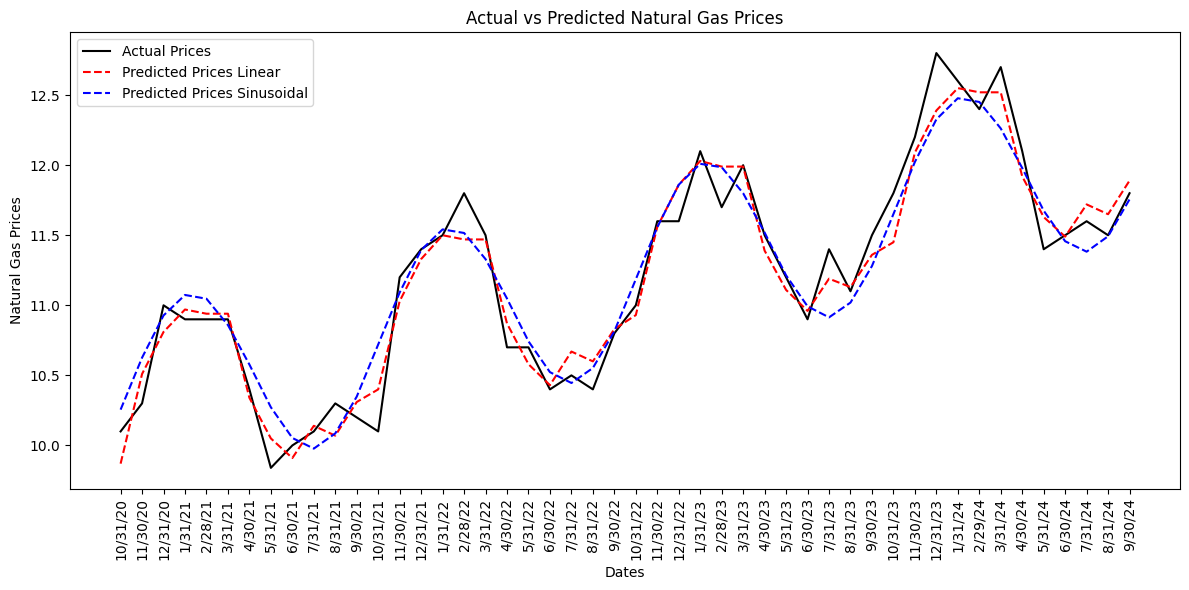

In [71]:
# To check how the model compares to the actual data. 

predicted_all_sinusoidal = trend_line + ((u * sine_time)) + (w * cosine_time)
predicted_all_linear = np.array([predict_price_linear(date) for date in df['Dates']])

plt.figure(figsize=(12,6))
plt.plot(dates, y, label ='Actual Prices', color ='Black')
plt.plot(dates, predicted_all_linear, label ='Predicted Prices Linear', color ='red', linestyle='--')
plt.plot(dates, predicted_all_sinusoidal, label ='Predicted Prices Sinusoidal', color ='blue', linestyle='--')
plt.xlabel('Dates')
plt.ylabel('Natural Gas Prices')
plt.title('Actual vs Predicted Natural Gas Prices') 
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [72]:
# Check with one is better
error_sinusoidal = y - predicted_all_sinusoidal # get residual amount compared to actual prices
error_linear = y - predicted_all_linear

squared_errors_sinusoidal = error_sinusoidal ** 2 # square the errors
squared_errors_linear = error_linear ** 2   

mean_squared_error_sinusoidal = np.mean(squared_errors_sinusoidal) # find the mean of the squared errors
mean_squared_error_linear = np.mean(squared_errors_linear)  

rmse_sinusoidal = np.sqrt(mean_squared_error_sinusoidal) # find the root mean squared error which gives a dollar amount
rmse_linear = np.sqrt(mean_squared_error_linear)

print(f'RMSE Sinusoidal Model: {rmse_sinusoidal:.3f}')
print(f'RMSE Linear Model: {rmse_linear:.3f}')
if rmse_sinusoidal < rmse_linear:
    print(f'Sinusoidal Model performs better than Linear Model by {rmse_linear - rmse_sinusoidal:.3f} in RMSE')
else:
    print(f'Linear Model performs better than Sinusoidal Model by {rmse_sinusoidal - rmse_linear:.3f} in RMSE')

RMSE Sinusoidal Model: 0.220
RMSE Linear Model: 0.167
Linear Model performs better than Sinusoidal Model by 0.053 in RMSE


In [77]:
while True:
    date_input = input("Enter a date (YYYY-MM-DD) to predict natural gas price (or 'q' to quit): ")
    if date_input.lower() == 'q':
        break
    try:
        predicted_price_linear = predict_price_linear(date_input)
        predicated_price_sinusoidal = predict_price_sinusoidal(date_input)
        print(f"Predicted natural gas price on {date_input} using Linear Regression: ${predicted_price_linear:.2f}")
        print(f"Predicted natural gas price on {date_input} using Sinusoidal Regression: ${predicated_price_sinusoidal:.2f}")

    except Exception as e:
        print(f"Error: {e}. Please enter a valid date in YYYY-MM-DD format.")

Predicted natural gas price on 2024-05-31 using Linear Regression: $11.63
Predicted natural gas price on 2024-05-31 using Sinusoidal Regression: $11.68


## Future Improvement to Tests: 

- Try daily time index instead of monthly to see if i can improve accuracy. 